In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import gymnasium as gym
import ale_py
import highway_env
from highway_env.envs.intersection_env import IntersectionEnv

from option_critic import OptionCriticFeatures
from attention_option_critic import AOCFeatures
from fourrooms_env import Fourrooms

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
BEST_PARAMS = {"cartpole": {"oc": {'num_options': 10, 'temperature': 1.3717722079389996, 'epsilon_start': 0.900845670626169, 'epsilon_min': 0.08330863818091966, 'epsilon_decay': 143651, 'gamma': 0.9719127696965757, 'tau': 0.9571360946012313, 'termination_reg': 0.008253268020968376, 'entropy_reg': 0.026949261891458975, 'hidden_size': 40, 'state_size': 56, 'hidden_size_2': 8, 'hidden_size_Q': 8, 'hidden_size_termination': 8, 'hidden_size_policy': 8, 'use_hidden_size': True, 'use_hidden_size_2': False, 'use_hidden_size_Q': False, 'use_hidden_size_termination': False, 'use_hidden_size_policy': False, 'learning_rate': 0.002872637446118515, 'batch_size': 224, 'critic_freq': 10, 'target_update_freq': 20, 'buffer_size': 4000},
                            "aoc": {'num_options': 9, 'temperature': 0.7014647237611604, 'epsilon_start': 0.9266293878140235, 'epsilon_min': 0.1477058909278815,  'epsilon_decay': 696722, 'gamma': 0.8995605059962165, 'tau': 0.9876976682663541, 'termination_reg': 0.02136841630458894, 'entropy_reg': 0.0072884705990544025, 'diversity_reg': 0.03153052105606061, 'sparsity_reg': 0.006558493362079418, 'smoothness_reg': 0.007593783252036938, 'hidden_size': 112, 'state_size': 32, 'hidden_size_2': 128, 'hidden_size_Q': 184, 'hidden_size_termination': 112, 'hidden_size_policy': 208, 'hidden_size_attention': 216, 'use_hidden_size': True, 'use_hidden_size_2': False, 'use_hidden_size_Q': False, 'use_hidden_size_termination': False, 'use_hidden_size_policy': False, 'use_hidden_size_attention': False, 'learning_rate': 0.001247281645969728,  'batch_size': 224, 'critic_freq': 80, 'target_update_freq': 15, 'buffer_size': 3000}},
               "fourrooms": {"oc": {'num_options': 7, 'temperature': 1.2736018552613575, 'epsilon_start': 0.898407044702919, 'epsilon_min': 0.11106037082599012, 'epsilon_decay': 2017100, 'gamma': 0.6355538088726308, 'tau': 0.994875240587202, 'termination_reg': 6.208141298922531, 'entropy_reg': 36.876883358671854, 'hidden_size': 176, 'state_size': 88, 'hidden_size_2': 176, 'hidden_size_Q': 64, 'hidden_size_termination': 32, 'hidden_size_policy': 168, 'use_hidden_size': True, 'use_hidden_size_2': True, 'use_hidden_size_Q': True, 'use_hidden_size_termination': True, 'use_hidden_size_policy': True, 'learning_rate': 1.2677056587562904e-05, 'batch_size': 288, 'critic_freq': 87, 'target_update_freq': 20, 'buffer_size': 9000},
                             "aoc": {'num_options': 8, 'temperature': 1.0536426187011056, 'epsilon_start': 0.8264763735738836, 'epsilon_min': 0.022082511682998233, 'epsilon_decay': 53736, 'gamma': 0.818407286978962, 'tau': 0.8320237025084155, 'termination_reg': 0.04510866229906666, 'entropy_reg': 379.2366376589341, 'diversity_reg': 0.2159038780752444, 'sparsity_reg': 0.0020696154768723666, 'smoothness_reg': 0.0005319766250548873, 'hidden_size': 40, 'state_size': 176, 'hidden_size_2': 128, 'hidden_size_Q': 184, 'hidden_size_termination': 112, 'hidden_size_policy': 208, 'hidden_size_attention': 216, 'use_hidden_size': False, 'use_hidden_size_2': True, 'use_hidden_size_Q': False, 'use_hidden_size_termination': False, 'use_hidden_size_policy': True, 'use_hidden_size_attention': True, 'learning_rate': 2.5355739894212796e-05, 'batch_size': 224, 'critic_freq': 127, 'target_update_freq': 33, 'buffer_size': 5000}},
               "highway": {"oc": {'num_options': 6, 'temperature': 1.2373617037978715, 'epsilon_start': 0.8677873957612043, 'epsilon_min': 0.0467816977436859, 'epsilon_decay': 416087, 'gamma': 0.8487674660379827, 'tau': 0.9539181690135505, 'termination_reg': 0.046733452793875675, 'entropy_reg': 0.014710831617644375, 'hidden_size': 112, 'state_size': 96, 'hidden_size_2': 128, 'hidden_size_Q': 184, 'hidden_size_termination': 112, 'hidden_size_policy': 208, 'hidden_size_attention': 216, 'use_hidden_size': True, 'use_hidden_size_2': False, 'use_hidden_size_Q': False, 'use_hidden_size_termination': False, 'use_hidden_size_policy': False, 'use_hidden_size_attention': False, 'learning_rate': 0.00010708727747293872, 'batch_size': 128, 'critic_freq': 80, 'target_update_freq': 15, 'buffer_size': 1000},
                           "aoc": {'num_options': 5, 'temperature': 0.6373385572352426, 'epsilon_start': 0.8171238944775601, 'epsilon_min': 0.12239294518867183, 'epsilon_decay': 125994, 'gamma': 0.5690343357871731, 'tau': 0.8452124313647141, 'termination_reg': 0.21226711201019122, 'entropy_reg': 171.6701976606381, 'diversity_reg': 0.06005124046477383, 'sparsity_reg': 0.014240748478285114, 'smoothness_reg': 0.0013370950267861373, 'hidden_size': 184, 'state_size': 136, 'hidden_size_2': 32, 'hidden_size_Q': 240, 'hidden_size_termination': 176, 'hidden_size_policy': 104, 'hidden_size_attention': 176, 'use_hidden_size': True, 'use_hidden_size_2': False, 'use_hidden_size_Q': True, 'use_hidden_size_termination': False, 'use_hidden_size_policy': True, 'use_hidden_size_attention': True, 'learning_rate': 0.0031004677606968497, 'batch_size': 480, 'critic_freq': 135, 'target_update_freq': 15, 'buffer_size': 10000}},
               "intersection": {"oc": {'num_options': 6, 'temperature': 1.2373617037978715, 'epsilon_start': 0.8677873957612043, 'epsilon_min': 0.0467816977436859, 'epsilon_decay': 416087, 'gamma': 0.8487674660379827, 'tau': 0.9539181690135505, 'termination_reg': 0.046733452793875675, 'entropy_reg': 0.014710831617644375, 'hidden_size': 112, 'state_size': 96, 'learning_rate': 0.00010708727747293872, 'batch_size': 128, 'critic_freq': 80, 'target_update_freq': 15, 'buffer_size': 1000},
                                "aoc": {'num_options': 6, 'temperature': 1.8671300818803704, 'epsilon_start': 0.8454802555665085, 'epsilon_min': 0.12087193121554306, 'epsilon_decay': 85220764, 'gamma': 0.6479896707028898, 'tau': 0.9955174070064012, 'termination_reg': 515.9261006747066, 'entropy_reg': 1.2887250769681522, 'diversity_reg': 1.4549608156402194, 'sparsity_reg': 0.01789134217066555, 'smoothness_reg': 0.00012311277844722553, 'hidden_size': 224, 'state_size': 96, 'hidden_size_2': 64, 'hidden_size_Q': 208, 'hidden_size_termination': 128, 'hidden_size_policy': 208, 'hidden_size_attention': 208, 'use_hidden_size': True, 'use_hidden_size_2': False, 'use_hidden_size_Q': False, 'use_hidden_size_termination': True, 'use_hidden_size_policy': True, 'use_hidden_size_attention': False, 'learning_rate': 0.00038763129437363944, 'batch_size': 416, 'critic_freq': 171, 'target_update_freq': 5, 'buffer_size': 12000}}}

In [3]:
ENV_IDX = 2
ENV_NAME =    ["CartPole-v1", "Fourrooms", "highway-fast-v0", "intersection-v1", "racetrack-v0", "ALE/Pong-v5"][ENV_IDX]
ENV_TYPE =    ["cartpole",    "fourrooms", "highway",         "intersection",    "racetrack",    "pong"][ENV_IDX]
RENDER_MODE = ["human",       "rgb_array", "rgb_array",       "rgb_array",       "rgb_array",    "human"][ENV_IDX]
TOTAL_TIMESTEPS = int(1e5)

- Feature input, Discrete action space
    - "CartPole-v1"      # (4,) --> 2
    - "LunarLander-v3"     # (8,) --> 4
    - "highway-fast-v0"  # (5, 5) --> 5
    - "intersection-v0"  # (15, 7) --> 3

- Feature input, Continuous action space
    - "intersection-v1"  # (5, 8) --> -1, 1, (2,)
    - "racetrack-v0"     # (2, 12, 12)

- Image input, Discrete action space
    - "ALE/Pong-v5"    # (210, 160, 3)


In [4]:
def get_model(env, env_type, model_type, train=False, record=False, save=False, total_timesteps=TOTAL_TIMESTEPS):
    model_params = BEST_PARAMS[env_type][model_type]
    
    if model_type == "aoc":
        model = AOCFeatures(
            env=env,
            num_options=model_params["num_options"],
            device="cpu",
            
            temperature=model_params["temperature"],
            epsilon_start=model_params["epsilon_start"],
            epsilon_min=model_params["epsilon_min"],
            epsilon_decay=model_params["epsilon_decay"],
            gamma=model_params["gamma"],
            tau=model_params["tau"],
            
            termination_reg=model_params["termination_reg"],
            entropy_reg=model_params["entropy_reg"],
            diversity_reg=model_params["diversity_reg"],
            sparsity_reg=model_params["sparsity_reg"],
            smoothness_reg=model_params["smoothness_reg"],
            
            hidden_size=model_params["hidden_size"],
            state_size=model_params["state_size"],
            hidden_size_2=model_params["hidden_size_2"],
            hidden_size_Q=model_params["hidden_size_Q"],
            hidden_size_termination=model_params["hidden_size_termination"],
            hidden_size_policy=model_params["hidden_size_policy"],
            hidden_size_attention=model_params["hidden_size_attention"],
            use_hidden_size=model_params["use_hidden_size"],
            use_hidden_size_2=model_params["use_hidden_size_2"],
            use_hidden_size_Q=model_params["use_hidden_size_Q"],
            use_hidden_size_termination=model_params["use_hidden_size_termination"],
            use_hidden_size_policy=model_params["use_hidden_size_policy"],
            use_hidden_size_attention=model_params["use_hidden_size_attention"],
            
            learning_rate=model_params["learning_rate"],
            batch_size=model_params["batch_size"],
            critic_freq=model_params["critic_freq"],
            target_update_freq=model_params["target_update_freq"],
            buffer_size=model_params["buffer_size"],
            tensorboard_log=f"results/{env_type}_{model_type}/" if record else None,
            verbose=0
        )
        
    elif model_type == "oc":
        model = OptionCriticFeatures(
            env=env,
            num_options=model_params["num_options"],
            device="cpu",
            
            temperature=model_params["temperature"],
            epsilon_start=model_params["epsilon_start"],
            epsilon_min=model_params["epsilon_min"],
            epsilon_decay=model_params["epsilon_decay"],
            gamma=model_params["gamma"],
            tau=model_params["tau"],
            
            termination_reg=model_params["termination_reg"],
            entropy_reg=model_params["entropy_reg"],
            
            hidden_size=model_params["hidden_size"],
            state_size=model_params["state_size"],
            hidden_size_2=model_params["hidden_size_2"],
            hidden_size_Q=model_params["hidden_size_Q"],
            hidden_size_termination=model_params["hidden_size_termination"],
            hidden_size_policy=model_params["hidden_size_policy"],
            use_hidden_size=model_params["use_hidden_size"],
            use_hidden_size_2=model_params["use_hidden_size_2"],
            use_hidden_size_Q=model_params["use_hidden_size_Q"],
            use_hidden_size_termination=model_params["use_hidden_size_termination"],
            use_hidden_size_policy=model_params["use_hidden_size_policy"],
            
            learning_rate=model_params["learning_rate"],
            batch_size=model_params["batch_size"],
            critic_freq=model_params["critic_freq"],
            target_update_freq=model_params["target_update_freq"],
            buffer_size=model_params["buffer_size"],
            tensorboard_log=f"results/{env_type}_{model_type}/" if record else None,
            verbose=0
        )

    if train:
        model.learn(total_timesteps=total_timesteps)
        if save:
            model.save(f"results/{env_type}_{model_type}/model")
    else:
        model.load(f"results/{env_type}_{model_type}/best_model")
        
    return model

In [5]:
def get_env():
    if ENV_TYPE == "fourrooms":
        env = Fourrooms()
        render_env = Fourrooms(render_mode=RENDER_MODE)
    elif ENV_TYPE == "intersection":
        intersection_config = IntersectionEnv.default_config()
        discrete_action = {'type': 'DiscreteAction', 
                        'longitudinal': False, 
                        'lateral': True, 
                        'target_speeds': [0, 5, 10]}
        intersection_config["observation"]["action"] = discrete_action
        intersection_config["action"] = discrete_action
        env = IntersectionEnv(config=intersection_config)
        render_env = IntersectionEnv(config=intersection_config, render_mode=RENDER_MODE)
    else:
        env = gym.make(ENV_NAME)
        render_env = gym.make(ENV_NAME, render_mode=RENDER_MODE)
        
    return env, render_env

In [6]:
# Note: This crashes if run in .ipynb instead of .py
def simulate_env(model, env, num_episodes=10):
    for episode in range(num_episodes):
        done = truncated = False
        obs, info = env.reset()
        option = None
        option_termination = True
        while not (done or truncated):
            option, action, logp, entropy = model.predict(obs, option, option_termination, testing=True)
            option_termination = model.get_option_termination(obs, option)
            obs, reward, done, truncated, info = env.step(action)
            env.render()
    env.close()

In [7]:
def visualize_stats(model, env, num_episodes=100):
    num_actions = env.action_space.n
    num_options = model.num_options
    option_actions = np.zeros((num_actions, num_options))
    
    # Collect data for visualizations
    episodic_rewards = [0]*num_episodes
    if ENV_TYPE == "fourrooms":
        state_visits = np.zeros_like(env.occupancy, dtype=np.float32)  # Fourrooms only
        option_terminations = np.zeros((num_options, *env.occupancy.shape), dtype=np.float32)   # Fourrooms only
        for episode in tqdm(range(num_episodes)):
            done = truncated = False
            obs, info = env.reset()
            option = None
            option_termination = True
            while not (done or truncated):
                option, action, logp, entropy = model.predict(obs, option, option_termination, testing=True)
                option_actions[action, option] += 1
                state_visits[env.curr_cell[0], env.curr_cell[1]] += 1   # Fourrooms only
                option_termination = model.get_option_termination(obs, option)
                if option_termination:  # Fourrooms only: Record option termination locations
                    option_terminations[option, env.curr_cell[0], env.curr_cell[1]] += 1
                obs, reward, done, truncated, info = env.step(action)
                episodic_rewards[episode] += reward
    else:
        for episode in tqdm(range(num_episodes)):
            done = truncated = False
            obs, info = env.reset()
            option = None
            option_termination = True
            while not (done or truncated):
                option, action, logp, entropy = model.predict(obs, option, option_termination, testing=True)
                option_actions[action, option] += 1
                option_termination = model.get_option_termination(obs, option)
                obs, reward, done, truncated, info = env.step(action)
                episodic_rewards[episode] += reward
        env.close()
    
    mean_reward = np.mean(episodic_rewards)
    median_reward = np.median(episodic_rewards)
    print(f"Mean Reward: {mean_reward}, Median Reward: {median_reward}")
    
    # 1. Primitive actions per option (Normalize across options)
    option_sums = option_actions.sum(axis=0)
    norm_option_actions = np.zeros_like(option_actions, dtype=float)
    for col in range(option_actions.shape[1]):
        if option_sums[col] > 0:
            norm_option_actions[:, col] = option_actions[:, col] / option_sums[col]

    plt.figure(figsize=(num_options+1, num_actions))
    plt.imshow(norm_option_actions, cmap="viridis", aspect="auto")
    plt.colorbar(label="Frequency")
    plt.xlabel("Options")
    plt.ylabel("Actions")
    plt.title("Distribution of Primitive Actions Per Option")
    plt.xticks(ticks=np.arange(num_options))
    plt.yticks(ticks=np.arange(num_actions))
    plt.show()
    
    # 2. Options per primitive action (Normalize across actions)
    action_sums = option_actions.sum(axis=1)
    norm_action_options = np.zeros_like(option_actions, dtype=float)
    for row in range(option_actions.shape[0]):
        if action_sums[row] > 0:
            norm_action_options[row, :] = option_actions[row, :] / action_sums[row]

    plt.figure(figsize=(num_options+1, num_actions))
    plt.imshow(norm_action_options, cmap="viridis", aspect="auto")
    plt.colorbar(label="Frequency")
    plt.xlabel("Options")
    plt.ylabel("Actions")
    plt.title("Distribution of Options Per Action (Normalized by Actions)")
    plt.xticks(ticks=np.arange(num_options))
    plt.yticks(ticks=np.arange(num_actions))
    plt.show()
    
    # 3. Histogram for total option usage
    option_totals = option_actions.sum(axis=0)
    total_usage = option_totals.sum()
    option_percent = (option_totals / total_usage) * 100
    
    plt.figure(figsize=(10, 5))
    bars = plt.bar(range(num_options), option_percent, color="steelblue")
    plt.xlabel("Options")
    plt.ylabel("Usage Percentage (%)")
    plt.title("Percentage Usage of Each Option")
    plt.xticks(ticks=np.arange(num_options))
    plt.ylim(0, option_percent.max() + 5)
    
    # Display the percentage number above each bar
    for i, bar in enumerate(bars):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1, 
                 f"{option_percent[i]:.2f}%", ha='center', va='bottom', fontsize=10)
    plt.show()
    
    # 4. Fourrooms only: State visitation heatmap
    if ENV_TYPE == "fourrooms":
        state_visits_max = state_visits.max()   # Normalize visits between 0 and 1
        state_visits_normalized = np.divide(
            state_visits, 
            state_visits_max, 
            where=state_visits_max != 0,        # Avoid division by zero
            out=np.zeros_like(state_visits)     # Default to 0 if can't divide
        )
        
        grid = np.array(env.occupancy, dtype=np.float32)            # Copy the occupancy grid
        heatmap = np.zeros_like(grid, dtype=np.float32)             # Initialize cells to 0
        heatmap[grid == 0] = state_visits_normalized[grid == 0]     # Copy visitation frequencies if cell is not a wall

        cmap = plt.cm.viridis
        heatmap_rgb = cmap(heatmap)[:, :, :3]   # Make heatmap using viridis
        heatmap_rgb[grid == 1] = [0, 0, 0]      # Set walls to black
        goal_cell = env.to_cell[env.goal]
        heatmap_rgb[goal_cell[0], goal_cell[1]] = [1, 0, 0]  # Set the goal cell to red

        plt.figure(figsize=(10, 10))
        plt.imshow(heatmap_rgb, aspect="equal")
        plt.xlabel("X Coordinate")
        plt.ylabel("Y Coordinate")
        plt.title("State Visitation Heatmap")
        plt.show()
    
    # 5. Fourrooms only: Option termination heatmap
    if ENV_TYPE == "fourrooms":
        option_terminations_max = option_terminations.max(axis=(1, 2), keepdims=True)   # Normalize terminations between 0 and 1
        option_terminations_normalized = np.divide(
            option_terminations, 
            option_terminations_max, 
            where=option_terminations_max != 0,     # Avoid division by zero
            out=np.zeros_like(option_terminations)  # Default to 0 if can't divide
        )
        
        for opt in range(num_options):
            grid = np.array(env.occupancy, dtype=np.float32)  # Copy the occupancy grid
            heatmap = np.zeros_like(grid, dtype=np.float32)   # Initialize cells to 0
            heatmap[grid == 0] = option_terminations_normalized[opt, grid == 0]  # Copy termination frequencies

            cmap = plt.cm.viridis
            heatmap_rgb = cmap(heatmap)[:, :, :3]  # Make heatmap using viridis
            heatmap_rgb[grid == 1] = [0, 0, 0]     # Set walls to black
            goal_cell = env.to_cell[env.goal]
            heatmap_rgb[goal_cell[0], goal_cell[1]] = [1, 0, 0]  # Set the goal cell to red

            plt.figure(figsize=(10, 10))
            plt.imshow(heatmap_rgb, aspect="equal")
            plt.xlabel("X Coordinate")
            plt.ylabel("Y Coordinate")
            plt.title(f"Option Termination Heatmap: Option {opt}")
            plt.colorbar(label="Normalized Termination Frequency")
            plt.show()

100%|██████████| 100/100 [00:38<00:00,  2.60it/s]

Mean Reward: 20.53070595696948, Median Reward: 21.020221169036326


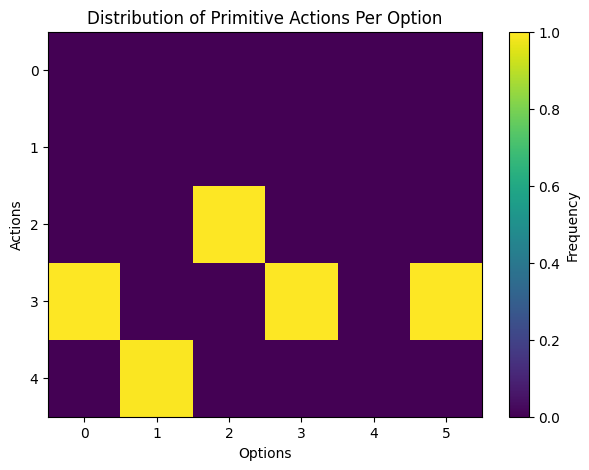

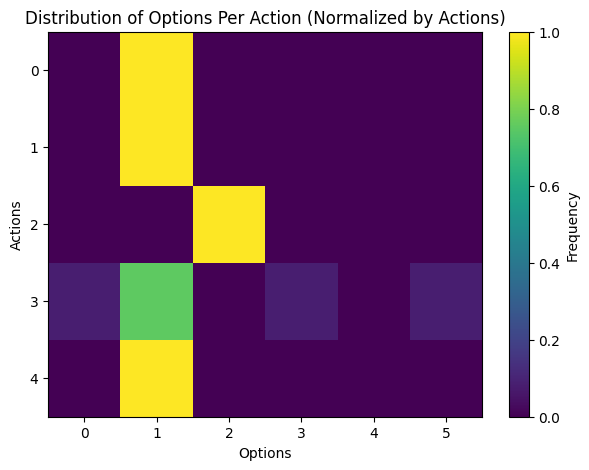

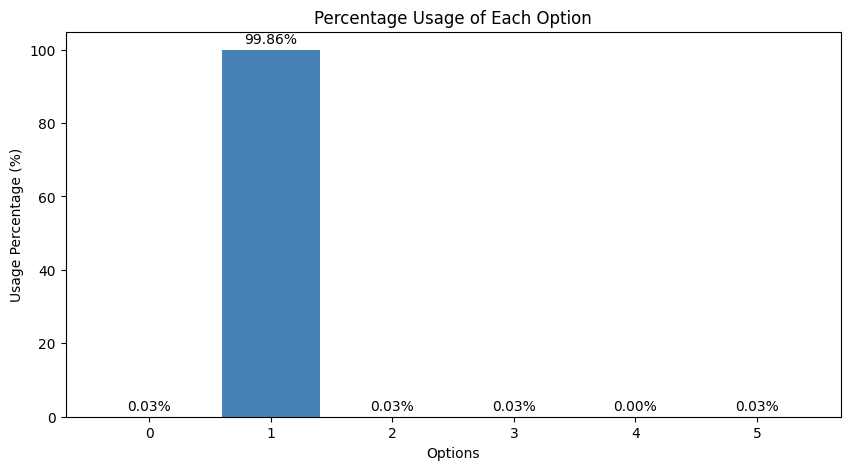

In [8]:
env, render_env = get_env()
oc = get_model(env=env, env_type=ENV_TYPE, model_type="oc", train=True, record=True, save=True)

# simulate_env(oc, render_env, num_episodes=10)
visualize_stats(oc, env=env, num_episodes=100)

In [9]:
# Visualize AOC attentions per option for each input feature
def visualize_attentions(model, env, num_episodes=10):
    num_features = model.in_features
    num_options = model.num_options
    option_attentions = np.zeros((num_options, num_features))
    
    # Collect data for visualizations
    for episode in tqdm(range(num_episodes)):
        done = truncated = False
        obs, info = env.reset()
        option = None
        option_termination = True
        while not (done or truncated):
            option, action, logp, entropy = model.predict(obs, option, option_termination, testing=True)
            
            _, attention_mask = model.apply_attention(obs, option)
            attention_mask = attention_mask.detach().cpu().numpy().squeeze()
            option_attentions[option, :] += attention_mask
            
            option_termination = model.get_option_termination(obs, option)
            obs, reward, done, truncated, info = env.step(action)
    env.close()
    
    # Normalize across options (feature contributions to each option sum to 1)
    option_sums = option_attentions.sum(axis=1, keepdims=True)
    norm_feature_per_option = np.zeros_like(option_attentions, dtype=float)
    for row in range(option_attentions.shape[0]):
        if option_sums[row] > 0:
            norm_feature_per_option[row, :] = option_attentions[row, :] / option_sums[row]

    plt.figure(figsize=(num_features + 1, num_options))
    plt.imshow(norm_feature_per_option, cmap="viridis", aspect="auto")
    plt.colorbar(label="Attention Weight")
    plt.xlabel("Features")
    plt.ylabel("Options")
    plt.title("Normalized Attention Distribution (Features per Option)")
    plt.xticks(ticks=np.arange(num_features))
    plt.yticks(ticks=np.arange(num_options))
    plt.show()

    # Normalize across features (option contributions to each feature sum to 1)
    feature_sums = option_attentions.sum(axis=0, keepdims=True)
    norm_option_per_feature = np.zeros_like(option_attentions, dtype=float)
    for col in range(option_attentions.shape[1]):
        if feature_sums[0, col] > 0:
            norm_option_per_feature[:, col] = option_attentions[:, col] / feature_sums[0, col]

    plt.figure(figsize=(num_features + 1, num_options))
    plt.imshow(norm_option_per_feature, cmap="plasma", aspect="auto")
    plt.colorbar(label="Attention Weight")
    plt.xlabel("Features")
    plt.ylabel("Options")
    plt.title("Normalized Attention Distribution (Options per Feature)")
    plt.xticks(ticks=np.arange(num_features))
    plt.yticks(ticks=np.arange(num_options))
    plt.show()

In [10]:
# Visualize AOC attentions for each option in Four Rooms
def visualize_attention_fourrooms(model, env, num_episodes=10):
    num_options = model.num_options
    grid_shape = env.occupancy.shape
    option_attentions = np.zeros((num_options, *grid_shape), dtype=np.float32)
    
    # Collect data for visualizations
    for episode in tqdm(range(num_episodes)):
        done = truncated = False
        obs, info = env.reset()
        option = None
        option_termination = True
        while not (done or truncated):
            option, action, logp, entropy = model.predict(obs, option, option_termination, testing=True)
            
            _, attention_mask = model.apply_attention(obs, option)
            attention_mask = attention_mask.detach().cpu().numpy().squeeze()
            
            # Accumulate attentions for each cell in the grid
            for cell, idx in env.to_state.items():
                option_attentions[option, cell[0], cell[1]] += attention_mask[idx]
            
            option_termination = model.get_option_termination(obs, option)
            obs, reward, done, truncated, info = env.step(action)
    env.close()
    
    # Normalize attentions for each option across the grid
    option_attentions_max = option_attentions.max(axis=(1, 2), keepdims=True)
    option_attentions_normalized = np.divide(
        option_attentions, 
        option_attentions_max, 
        where=option_attentions_max != 0,       # Avoid division by zero
        out=np.zeros_like(option_attentions)    # Default to 0 if can't divide
)

    # Plot attention heatmaps for each option
    for opt in range(num_options):
        heatmap = option_attentions_normalized[opt]
        cmap = plt.cm.viridis
        heatmap_rgb = cmap(heatmap)[:, :, :3]  # Use viridis colormap
        heatmap_rgb[env.occupancy == 1] = [0, 0, 0]  # Set walls to black
        goal_cell = env.to_cell[env.goal]
        heatmap_rgb[goal_cell[0], goal_cell[1]] = [1, 0, 0]  # Set the goal cell to red

        plt.figure(figsize=(10, 10))
        plt.imshow(heatmap_rgb, aspect="equal")
        plt.xlabel("X Coordinate")
        plt.ylabel("Y Coordinate")
        plt.title(f"Attention Heatmap for Option {opt}")
        plt.colorbar(label="x")
        plt.show()


100%|██████████| 100/100 [00:24<00:00,  4.07it/s]

Mean Reward: 13.492405344986878, Median Reward: 12.766355692504312


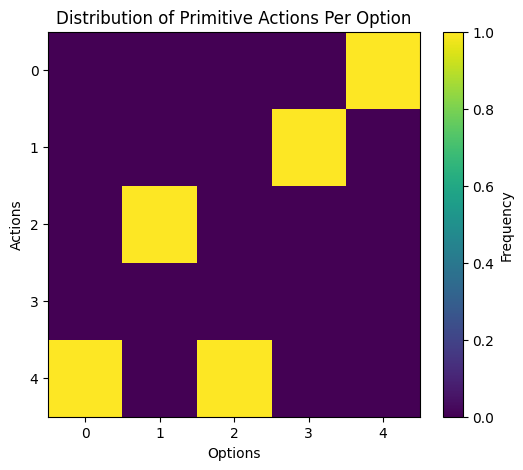

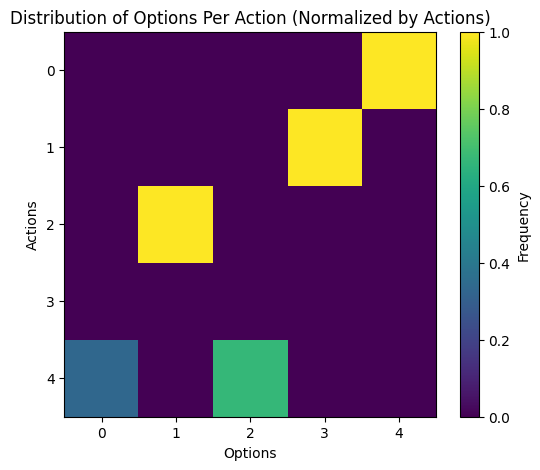

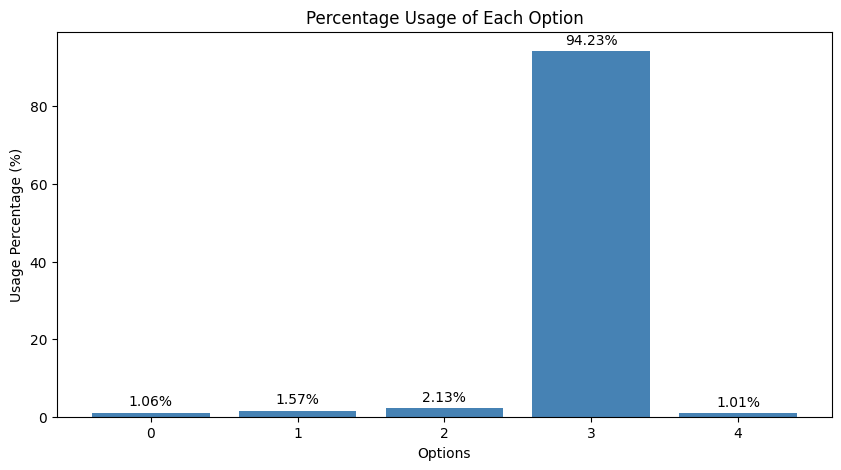

100%|██████████| 100/100 [00:23<00:00,  4.34it/s]


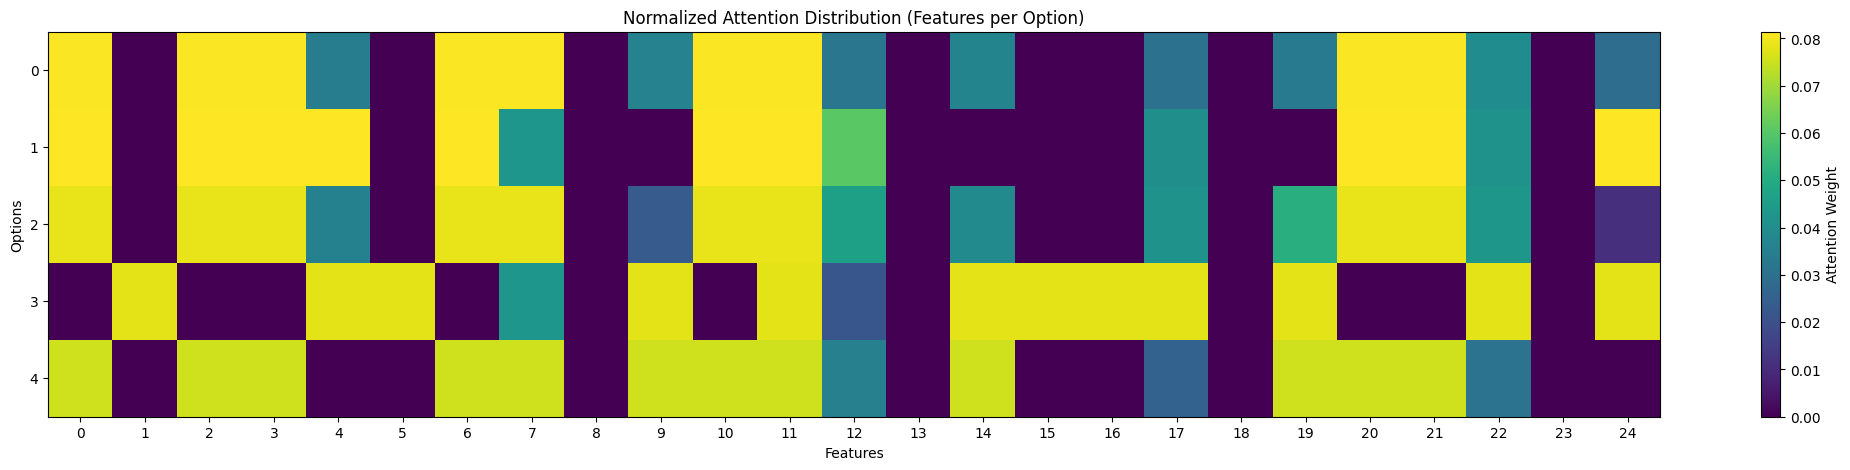

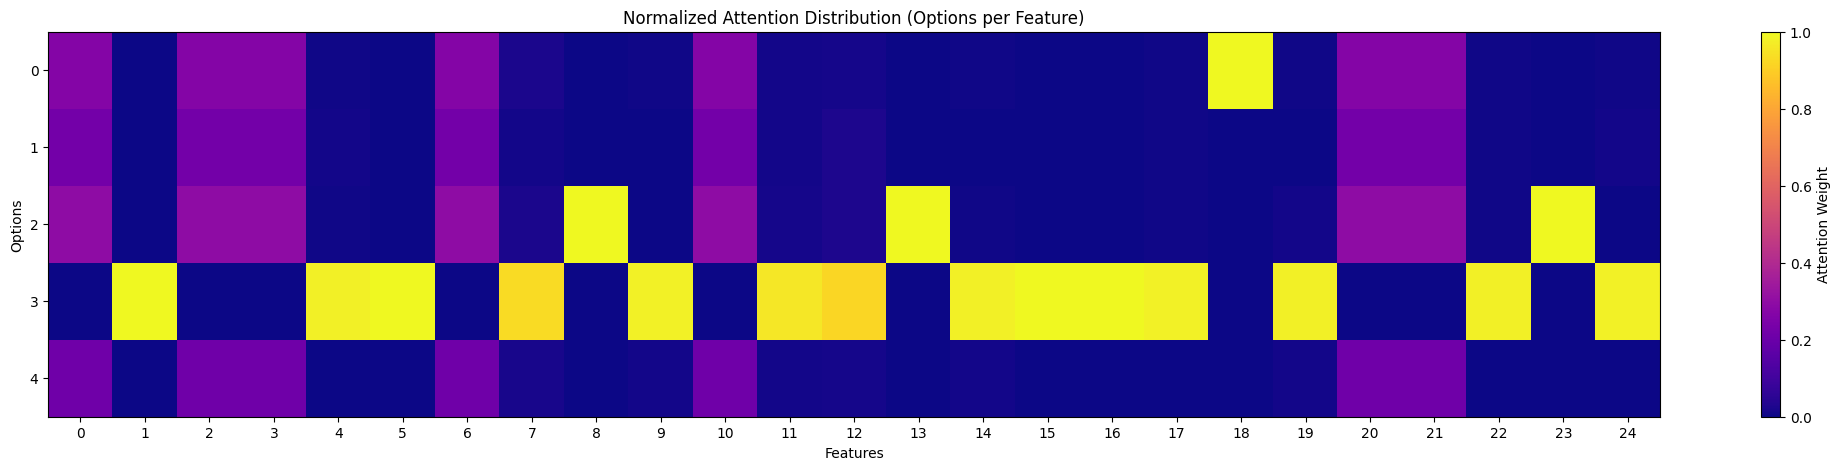

In [11]:
env, render_env = get_env()
aoc = get_model(env=env, env_type=ENV_TYPE, model_type="aoc", train=True, record=True, save=True)

# simulate_env(aoc, env=render_env, num_episodes=1)
visualize_stats(aoc, env=env, num_episodes=100)
visualize_attentions(aoc, env=env, num_episodes=100)
# visualize_attention_fourrooms(aoc, env=env, num_episodes=100)